# self-attention

## setup

In [1113]:
import numpy as np
import math
import copy
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1114]:
EMBED_SIZE = 20
N_HEADS = 4
VOCAB_SIZE = 11
HIDDEN_SIZE = 32
CONTEXT_SIZE = 10
MAGIC_TOKEN = VOCAB_SIZE - 1
EPOCHS = 10000
LEARNING_RATE = 3e-4
DROPOUT = 0.1

In [1115]:
X = []
Y = []

for i in range(10000):
  magic_token_idx = random.randint(1, CONTEXT_SIZE/2 - 1)
  x = [random.randint(1,VOCAB_SIZE-2) for _ in range(magic_token_idx)] + [MAGIC_TOKEN] + [0 for _ in range(CONTEXT_SIZE - magic_token_idx - 1)]
  y = x[:magic_token_idx+1] + x[:magic_token_idx] + [0 for _ in range(CONTEXT_SIZE - 2 * magic_token_idx - 1)]
  X.append(x)
  Y.append(y)

X = torch.tensor(X).to(device)
Y= torch.tensor(Y).to(device)

## code

In [1116]:
activations = {}

def create_positional_encoding(context_size=CONTEXT_SIZE, embed_size=EMBED_SIZE):
    '''sinusoidal positional encoding - see Attention is all you need'''
    position = torch.arange(context_size).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_size, 2) * -(math.log(10000.0) / embed_size))
    positional_encoding = torch.zeros(context_size, embed_size)
    positional_encoding[:, 0::2] = torch.sin(position * div_term)
    positional_encoding[:, 1::2] = torch.cos(position * div_term)
    return positional_encoding.to(device)

class MultiheadAttention(nn.Module):
  def __init__(self, n_heads, embed_size, dropout):
    super().__init__()
    assert embed_size % n_heads == 0, f'{embed_size=} should be divisible by {n_heads=}'
    self.n_heads = n_heads
    self.embed_size = embed_size
    self.dropout_rate = dropout
    self.qkv = nn.Linear(embed_size, embed_size * 3) # generate Q, K, V all at once
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, C, _ = x.shape
    # q, k, v = self.qkv(x).split(self.embed_size, dim=-1)
    q, k, v = self.qkv(x).chunk(3, dim=-1)
    q = q.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    k = k.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    v = v.view(B, C, self.n_heads, self.embed_size // self.n_heads).transpose(1, 2)
    y = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_rate if self.training else 0.)
    y = y.transpose(1, 2).contiguous().view(B, C, self.embed_size)
    y = self.dropout(y)
    return y

class Attention(nn.Module):
  def __init__(self, embed_size, dropout):
    super().__init__()
    self.w_key = torch.nn.Linear(embed_size, embed_size, bias=False)
    self.w_query = torch.nn.Linear(embed_size, embed_size, bias=False)
    self.w_value = torch.nn.Linear(embed_size, embed_size, bias=False)
    self.ln = nn.LayerNorm(embed_size)
    self.attn_dropout = nn.Dropout(dropout)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    # generate K,Q,V
    key = self.w_key(x)
    query = self.w_query(x)
    value = self.w_value(x)
    # pre-layernorm
    x = self.ln(x)
    # do the attention
    correlation = query @ key.transpose(-2, -1)
    correlation = correlation / math.sqrt(key.shape[-1])
    correlation = F.softmax(correlation, dim=-1)
    activations['x'] = correlation.detach()
    correlation = self.attn_dropout(correlation)
    new_embedding = correlation @ value
    # post-layernorm
    # new_embedding = self.ln(new_embedding)
    new_embedding = self.dropout(new_embedding)
    return new_embedding

class Net(nn.Module):
  def __init__(self, learned_positional_encoding=True, multihead=False, n_heads=N_HEADS, embed_size=EMBED_SIZE, dropout=DROPOUT, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE, context_size=CONTEXT_SIZE):
    super().__init__()
    self.use_learned_positional_encoding = learned_positional_encoding
    self.context_size = context_size
    # net
    self.token_embedding = nn.Embedding(vocab_size, embed_size)
    self.positional_embedding = nn.Embedding(context_size, embed_size) if learned_positional_encoding else create_positional_encoding()
    self.attention = MultiheadAttention(n_heads, embed_size, dropout=dropout) if multihead else Attention(embed_size, dropout=dropout)
    self.ff = nn.Sequential(
      nn.LayerNorm(embed_size), # pre-layernorm
      nn.Linear(embed_size, hidden_size),
      nn.ReLU(),
      nn.Linear(hidden_size, embed_size),
      # nn.LayerNorm(EMBED_SIZE), # post-layernorm
      nn.Dropout(dropout)
    )
    self.head = nn.Linear(embed_size, vocab_size)

  def forward(self, x):
    # (batch_size, context_size)
    x = self.token_embedding(x)  # (batch_size, context_size, embedding_size)
    # positional encoding
    x = x + self.get_positional_embedding()
    # attention
    x = x + self.attention(x)
    # feed forward
    x = x + self.ff(x)
    # head
    x = self.head(x)
    return x
  
  def get_positional_embedding(self):
    if self.use_learned_positional_encoding:
      return self.positional_embedding(torch.arange(0, self.context_size).to(device))
    else:
      return self.positional_embedding
    
  def get_positional_embeddings(self):
    return self.get_positional_embedding().detach().cpu()

In [1117]:
model = Net(learned_positional_encoding=True, multihead=True).to(device)
positional_embeddings = []

In [1118]:
def train(model, epochs=EPOCHS, lr=LEARNING_RATE):
  model.train()
  opt = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(epochs):
    out = model(X)
    loss = F.cross_entropy(out.view(-1, out.shape[-1]), Y.view(-1))
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 10 == 0:
      positional_embeddings.append(model.get_positional_embeddings())
    if epoch % 500 == 0:
      print(f'{epoch:5} {loss.item()}')

train(model, epochs=10000, lr=3e-4)

    0 2.4430503845214844
  500 0.5622162818908691
 1000 0.1585092395544052
 1500 0.054433319717645645
 2000 0.03737412393093109
 2500 0.03109278716146946
 3000 0.02616857923567295
 3500 0.023180898278951645
 4000 0.021424010396003723
 4500 0.020566625520586967
 5000 0.017895236611366272
 5500 0.016997499391436577
 6000 0.016244441270828247
 6500 0.015009974129498005
 7000 0.0133435083553195
 7500 0.013980617746710777
 8000 0.012763877399265766
 8500 0.012820006348192692
 9000 0.012254202738404274
 9500 0.011726586148142815


In [1119]:
model.eval()
res = model(X).argmax(-1)
correct = ((res == Y).float().sum(-1) == CONTEXT_SIZE).float().sum()
print(f'accuracy: {correct / len(X)}')
res[:5]

accuracy: 1.0


tensor([[ 4,  9,  7, 10,  4,  9,  7,  0,  0,  0],
        [ 8,  2, 10,  8,  2,  0,  0,  0,  0,  0],
        [ 2,  4,  8,  1, 10,  2,  4,  8,  1,  0],
        [ 2,  1,  1,  6, 10,  2,  1,  1,  6,  0],
        [ 4,  8,  1,  2, 10,  4,  8,  1,  2,  0]], device='cuda:0')

In [1120]:
model.eval()
res = model(torch.tensor([[7,1,9,2,10,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[1,2,10,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,10,0,0,0,0,0,0,0,0]]).to(device)).argmax(-1)
# res = model(torch.tensor([[8,3,4,10,0,0,0,0,0,0]]).to(device)).argmax(-1)
print(res)

_ = plt.imshow(activations['x'].squeeze().cpu())

tensor([[ 7,  1,  9,  2, 10,  7,  1,  9,  2,  0]], device='cuda:0')


KeyError: 'x'

In [ ]:
# save
# ----
# torch.save(model.state_dict(), 'weights/copy-task-500k-epochs.pt')

# load
# ----
# m = Net().to(device)
# m.load_state_dict(torch.load('weights/copy-task-500k-epochs.pt'))

## testing ideas

ideas requiring positional encoding / attention:
1) additions using LLM
2) arithmetic / geometric sequence prediction 1, 3, 5 ? → 7  or 2, 4, 8, ? → 16
3) (BOW?) sort 1, 3, 2, 4, 1 → 1, 1, 2, 3, 4
4) parens summation: (2 2 3) (4 5) → 7, 9
5) substring extraction between markers: 1, 4, 56, 10, 43, 54, 56, 6, 10 → 43, 54, 56, 6

## visualize positional embeddings

### dotproduct / cosine distance

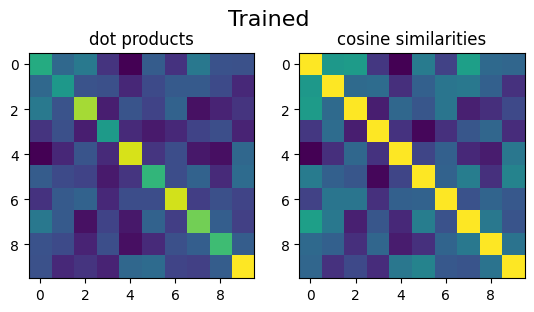

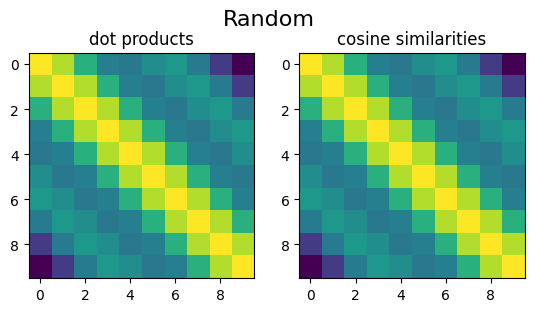

In [ ]:
def plot_positional_embeddings_relations(model, title):
    x = model.get_positional_embeddings()
    dot_products = x @ x.T
    x_norm = x / x.norm(dim=1, keepdim=True)
    cosine_similarities = x_norm @ x_norm.T
    # plot
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(dot_products)
    ax[0].set_title('dot products')
    ax[1].imshow(cosine_similarities)
    ax[1].set_title('cosine similarities')
    fig.text(0.5, 0.8, title, ha='center', va='center', fontsize=16)
    plt.show()

m2 = Net(learned_positional_encoding=False).to(device)
plot_positional_embeddings_relations(model, 'Trained')
plot_positional_embeddings_relations(m2, 'Random')

### PCA

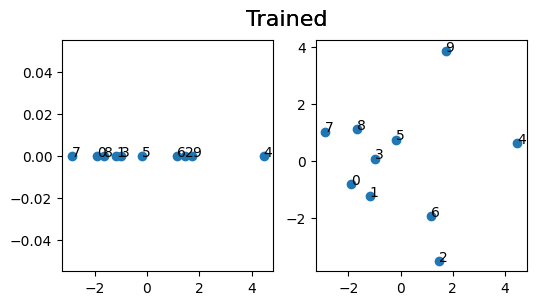

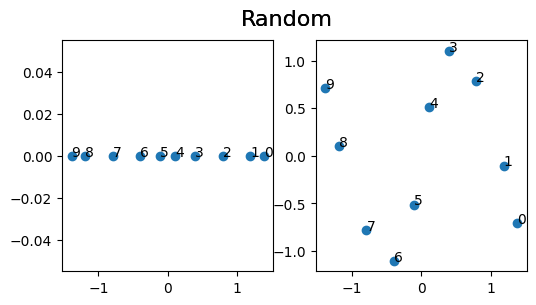

In [ ]:
def plot_positional_embeddings_pca(model, title='', figsize=(6, 3)):
    def reduce_dims(x, dim):
        pca = PCA(n_components=dim)
        y = pca.fit_transform(x)
        if dim == 1: return y[:, 0], np.zeros_like(y[:, 0])
        return y[:, 0], y[:, 1]

    x = model.get_positional_embeddings()
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    for j, dim in enumerate([1, 2]):
        xs, ys = reduce_dims(x, dim)
        # plot
        ax[j].scatter(xs, ys, label=f'pca dim={dim}')
        for i in range(xs.shape[0]):
            ax[j].annotate(f'{i}', xy=(xs[i], ys[i]))
        fig.text(0.5, 0.95, title, ha='center', va='center', fontsize=16)

m2 = Net(learned_positional_encoding=False).to(device)
plot_positional_embeddings_pca(model, 'Trained')
plot_positional_embeddings_pca(m2, 'Random')

### over time

In [ ]:
def get_frame(pe, ax):
    def f(step):
        x = pe[step]
        gamma = 1/(F.pdist(torch.tensor(x))).median().float().item()
        xs, ys = x[:, 0], x[:, 1]
        ax.clear()
        ax.set_title(f'step {step} gamma {gamma:.4f}')
        ax.scatter(xs, ys, label='')
        for i in range(xs.shape[0]):
            ax.annotate(f'{i}', xy=(xs[i], ys[i]))
    return f

def animate_positional_embeddings(pe, figsize=(3, 3)):
    fig, ax = plt.subplots(figsize=figsize)
    ani = FuncAnimation(fig, get_frame(pe, ax), frames=len(pe), interval=50, repeat=False)
    plt.close()
    return ani

pes = positional_embeddings[::10]
# optional PCA if we are running embeddings with more than 2 dimensions
if pes[0].shape[-1] > 2:
    # pes = [PCA(n_components=2).fit_transform(x) for x in pes]
    pes = [KernelPCA(n_components=2, kernel='rbf', gamma=1/(F.pdist(x)).median().float().item()).fit_transform(x) for x in pes]

ani = animate_positional_embeddings(pes)
display(HTML(ani.to_jshtml())) # display inline

In [ ]:
# ani.save('gifs/learned-2d-short.gif', fps=20) # save to disk